In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import pathlib
import time
import datetime
import shutil
from glob import glob

from matplotlib import pyplot as plt
from IPython import display

In [15]:
input_path = '..\\p2p_input_map\\'
point_path = '..\\point_folder\\'
target_path = '..\\binary2\\'

In [16]:
pic = np.zeros([1,1])
def cross_validation(validnum):
    shutil.rmtree(point_path + 'train')
    shutil.rmtree(point_path + 'test')
    os.mkdir(point_path + 'train')
    os.mkdir(point_path + 'test')
    for i in range(5):
        files = glob(point_path + 'group' + str(i) + '\\*.png')
        if i == validnum:
            for file in files:
                name = list(file.split('\\'))[-1]
                cv2.imwrite(point_path + 'test\\' + name, pic)
        else:
            for file in files:
                name = list(file.split('\\'))[-1][:-4]
                cv2.imwrite(point_path + 'train\\' + name + '.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_0.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_1.png', pic)
                cv2.imwrite(point_path + 'train\\' + name + '_2.png', pic)

In [17]:
validnum = 1
cross_validation(validnum)

In [18]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 4
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
# @tf.function
# def load_image(point_file):
#     name = tf.strings.split(point_file,'\\')[-1]

#     inpu = tf.io.read_file(input_path + name)
#     tar = tf.io.read_file(target_path + name)
#     inpu = tf.image.decode_png(inpu)
#     tar = tf.image.decode_png(tar)
    
#     inpu = (tf.cast(inpu, tf.float32) / 127.5) - 1
#     tar = (tf.cast(tar, tf.float32) / 127.5) - 1

#     return inpu, tar

In [19]:

@tf.function
def load(point_file):
    name = tf.strings.split(point_file,'\\')[-1]

    inpu = tf.io.read_file(input_path + name)
    tar = tf.io.read_file(target_path + name)
    inpu = tf.image.decode_png(inpu)
    tar = tf.image.decode_png(tar)
    
    inpu = tf.cast(inpu, tf.float32)
    tar = tf.cast(tar, tf.float32)

    return inpu, tar

In [20]:

# def resize(input_image, real_image, height, width):
# #   input_image = tf.image.resize(input_image, [height, width],
# #                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#   real_image = tf.image.resize(real_image, [height, width],
#                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   return input_image, real_image

In [21]:

def random_crop(input_image, real_image):
#   stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(real_image, size=[IMG_HEIGHT, IMG_WIDTH, 1])

  return input_image, cropped_image

In [22]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [23]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
#   input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
#     input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  if tf.random.uniform(()) > 0.5:
    # Random mirroring
#     input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_up_down(real_image)

  return input_image, real_image

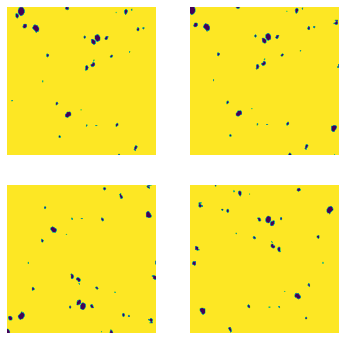

In [24]:
inp, re = load(str(point_path + 'train\\6s1v 2.5x-0007.png'))
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
#     print(rj_inp, rj_re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_re / 255.0)
    plt.axis('off')
plt.show()

In [13]:
def load_image_train(point_file):
  input_image, real_image = load(point_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
def load_image_test(point_file):
  input_image, real_image = load(point_file)
#   input_image, real_image = resize(input_image, real_image,
#                                    IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [15]:
train_dataset = tf.data.Dataset.list_files(point_path + 'train\\*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [16]:
test_dataset = tf.data.Dataset.list_files(point_path+'test\\*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
# train_dataset = tf.data.Dataset.list_files(point_path + 'train\\*.png')
# train_dataset = train_dataset.map(load_image,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)#.repeat()

In [18]:
# test_dataset = tf.data.Dataset.list_files(point_path+'test\\*.png')
# test_dataset = test_dataset.map(load_image)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [19]:
OUTPUT_CHANNELS = 1

In [20]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [21]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [22]:
# ORIGINAL VERSION
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 4])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
# 把skip去掉的版本 好像不工作呢
# def Generator():
#   inputs = tf.keras.layers.Input(shape=[256, 256, 4])

#   down_stack = [
#     downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
#     downsample(128, 4),  # (batch_size, 64, 64, 128)
#     downsample(256, 4),  # (batch_size, 32, 32, 256)
#     downsample(512, 4),  # (batch_size, 16, 16, 512)
#     downsample(512, 4),  # (batch_size, 8, 8, 512)
#     downsample(512, 4),  # (batch_size, 4, 4, 512)
#     downsample(512, 4),  # (batch_size, 2, 2, 512)
#     downsample(512, 4),  # (batch_size, 1, 1, 512)
#   ]

#   up_stack = [
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
#     upsample(512, 4),  # (batch_size, 16, 16, 1024)
#     upsample(256, 4),  # (batch_size, 32, 32, 512)
#     upsample(128, 4),  # (batch_size, 64, 64, 256)
#     upsample(64, 4),  # (batch_size, 128, 128, 128)
#   ]

#   initializer = tf.random_normal_initializer(0., 0.02)
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh')  # (batch_size, 256, 256, 3)

#   x = inputs

#   # Downsampling through the model
# #   skips = []
#   for down in down_stack:
#     x = down(x)
# #     skips.append(x)

# #   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up in up_stack:
#     x = up(x)
# #     x = tf.keras.layers.Concatenate()([x, skip])

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)

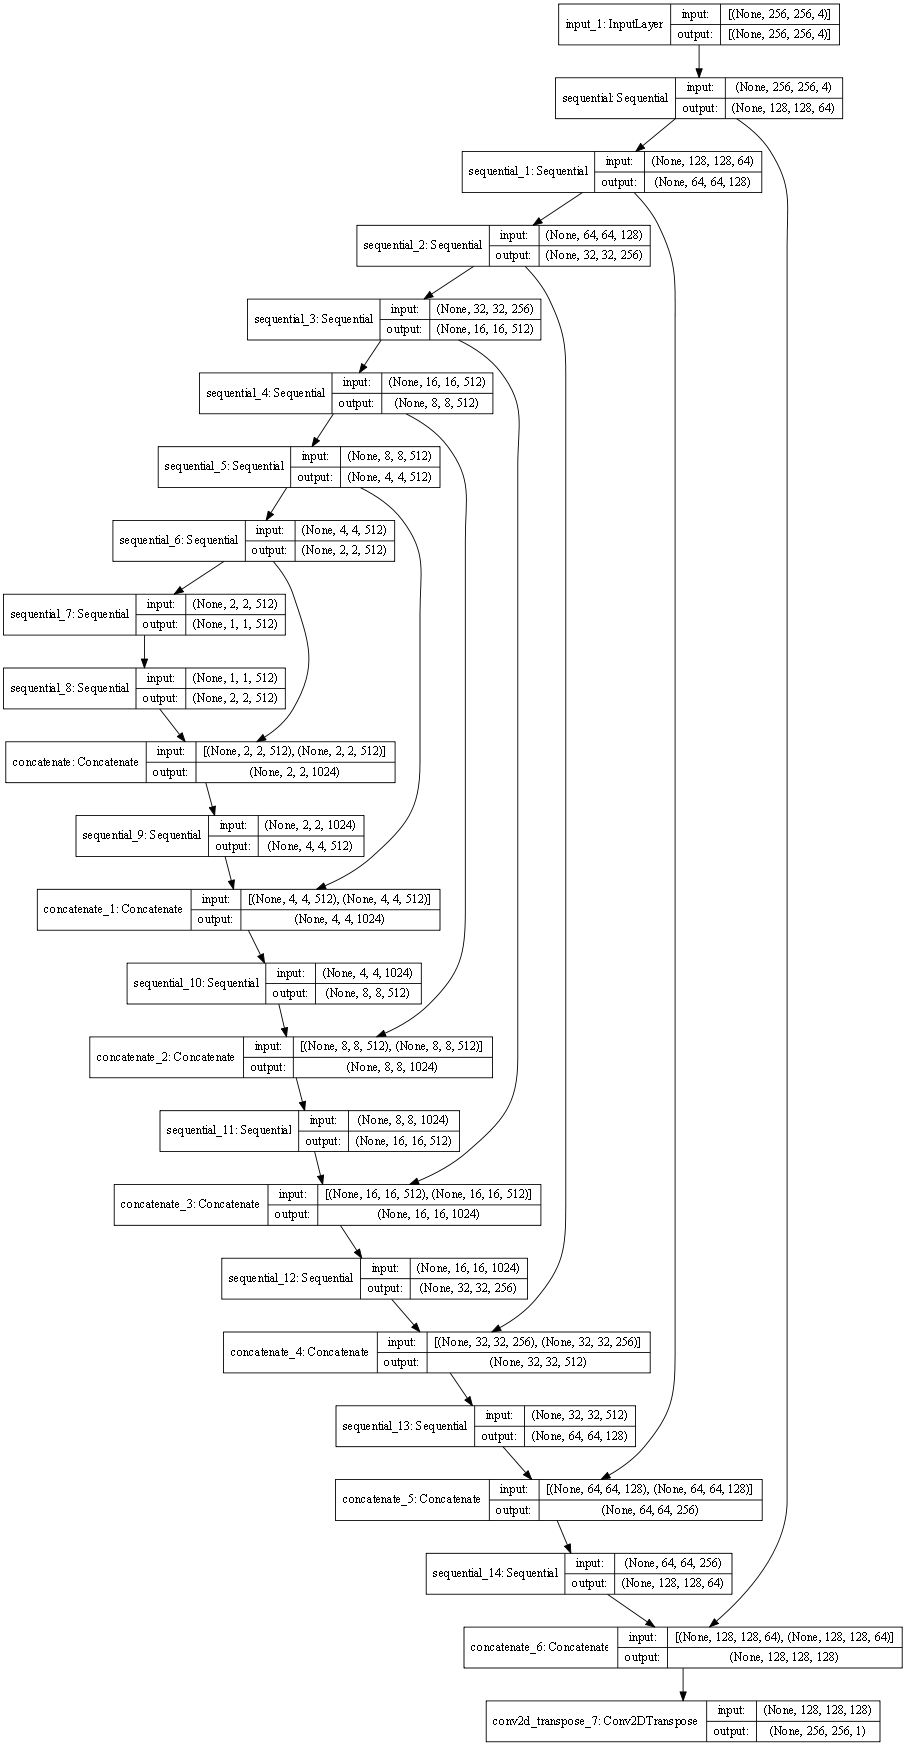

In [24]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [25]:
# 这里是输入5个参数先dense layer再upsample的版本
# def Generator():
#     inputs = tf.keras.layers.Input(shape=[1, 1, 5]) #这里也可以试试直接upsample
#     x = tf.keras.layers.Flatten()(inputs)
#     x = tf.keras.layers.Dense(16)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dense(64)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dense(256)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dense(512)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Reshape((1, 1, -1))(x)
    
#     x = upsample(x, 512, 4, apply_dropout=True) # (batch_size, 2, 2, 1024)
#     x = upsample(x, 512, 4, apply_dropout=True) # (batch_size, 4, 4, 1024)
#     x = upsample(x, 512, 4, apply_dropout=True)  # (batch_size, 8, 8, 1024)
#     x = upsample(x, 512, 4)  # (batch_size, 16, 16, 1024)
#     x = upsample(x, 256, 4)  # (batch_size, 32, 32, 512)
#     x = upsample(x, 128, 4) # (batch_size, 64, 64, 256)
#     x = upsample(x, 64, 4)  # (batch_size, 128, 128, 128)
#     initializer = tf.random_normal_initializer(0., 0.02)
#     last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh')  # (batch_size, 256, 256, 3)
    
# #     x = up_stack(x)
#     x = last(x)
# #     x = tf.keras.layers.Conv2DTranspose(512, (1,1), strides=1)(x)
#     return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
LAMBDA = 100

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 4], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')
    



    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

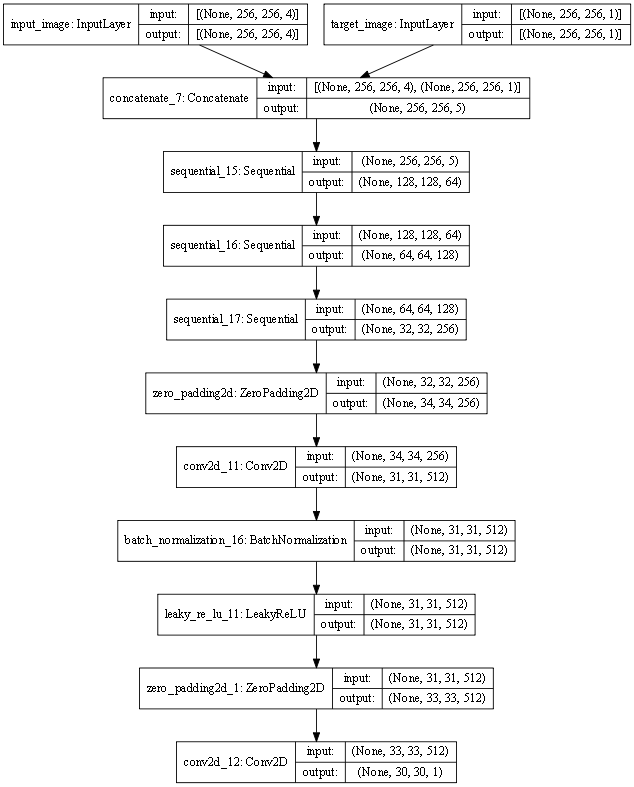

In [30]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

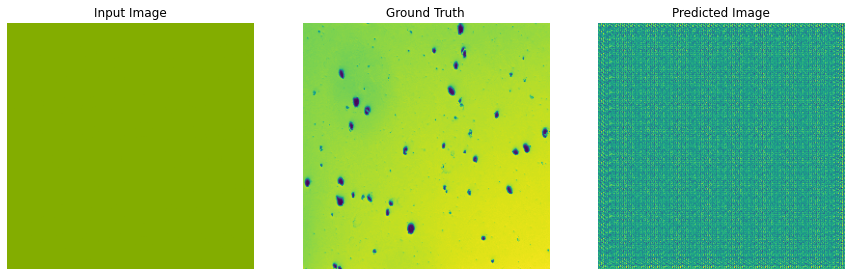

In [35]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [36]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [38]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 53.09 sec



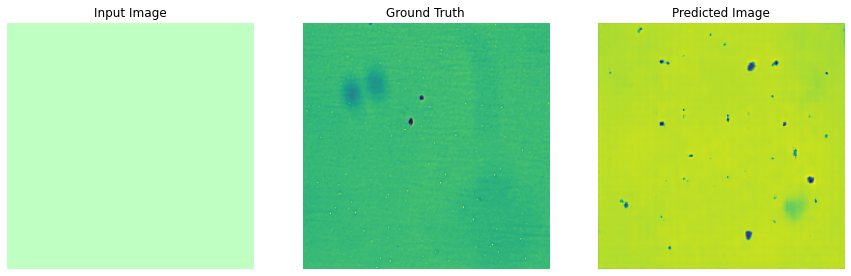

Step: 119k
....................................................................................................

In [39]:
fit(train_dataset, test_dataset, steps=120000)

In [40]:
!ls {checkpoint_dir}

checkpoint
ckpt-1.data-00000-of-00001
ckpt-1.index
ckpt-10.data-00000-of-00001
ckpt-10.index
ckpt-11.data-00000-of-00001
ckpt-11.index
ckpt-12.data-00000-of-00001
ckpt-12.index
ckpt-13.data-00000-of-00001
ckpt-13.index
ckpt-14.data-00000-of-00001
ckpt-14.index
ckpt-15.data-00000-of-00001
ckpt-15.index
ckpt-16.data-00000-of-00001
ckpt-16.index
ckpt-17.data-00000-of-00001
ckpt-17.index
ckpt-18.data-00000-of-00001
ckpt-18.index
ckpt-19.data-00000-of-00001
ckpt-19.index
ckpt-2.data-00000-of-00001
ckpt-2.index
ckpt-20.data-00000-of-00001
ckpt-20.index
ckpt-21.data-00000-of-00001
ckpt-21.index
ckpt-22.data-00000-of-00001
ckpt-22.index
ckpt-23.data-00000-of-00001
ckpt-23.index
ckpt-24.data-00000-of-00001
ckpt-24.index
ckpt-25.data-00000-of-00001
ckpt-25.index
ckpt-26.data-00000-of-00001
ckpt-26.index
ckpt-27.data-00000-of-00001
ckpt-27.index
ckpt-28.data-00000-of-00001
ckpt-28.index
ckpt-29.data-00000-of-00001
ckpt-29.index
ckpt-3.data-00000-of-00001
ckpt-3.index
ckpt-30.data-00000-of-00001
c

In [41]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [48]:
def save_generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    pic = np.concatenate([tar[0] * 0.5 + 0.5, np.ones([256, 6, 1]), prediction[0] * 0.5 + 0.5], axis=1)
    return pic

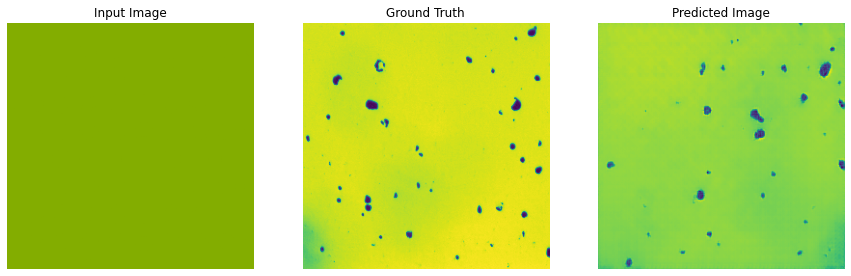

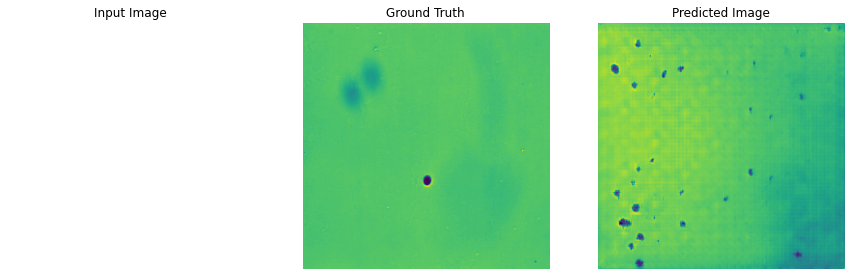

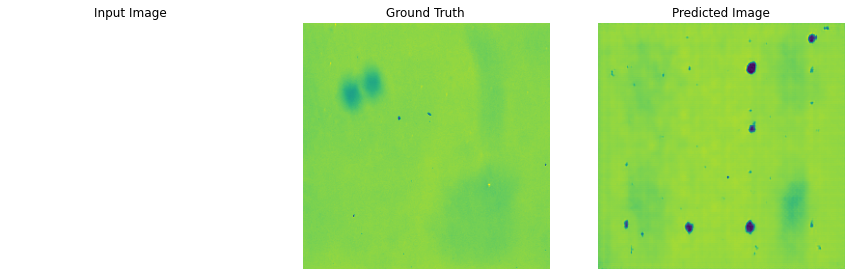

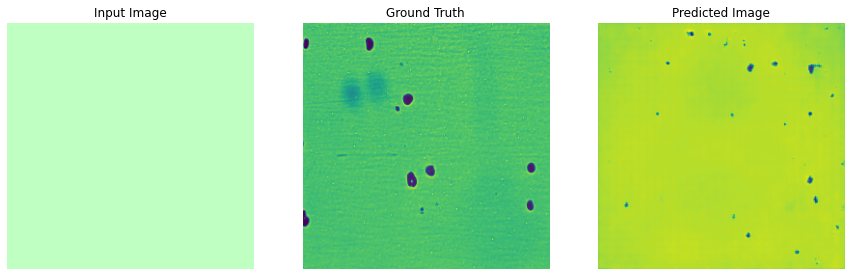

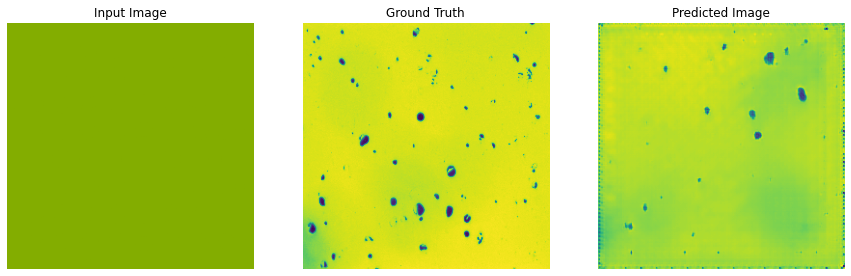

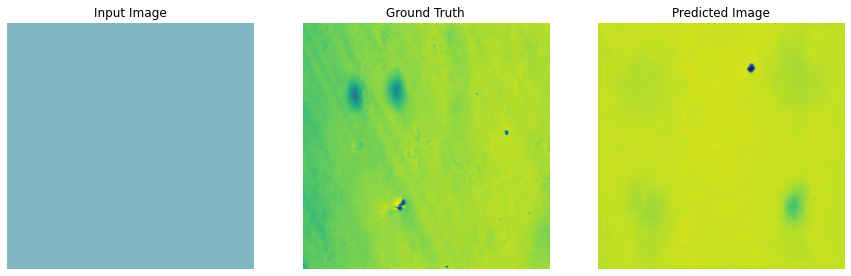

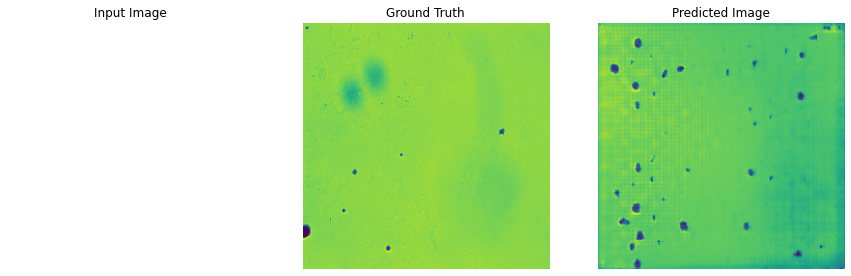

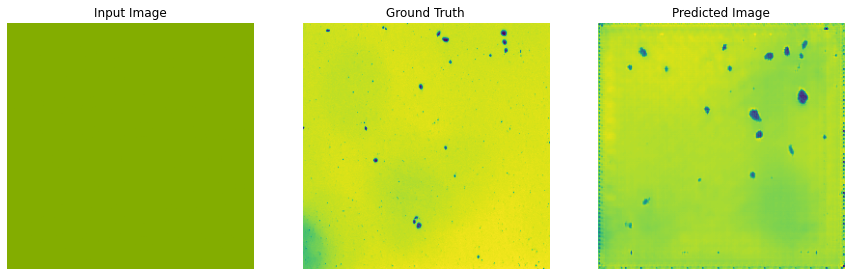

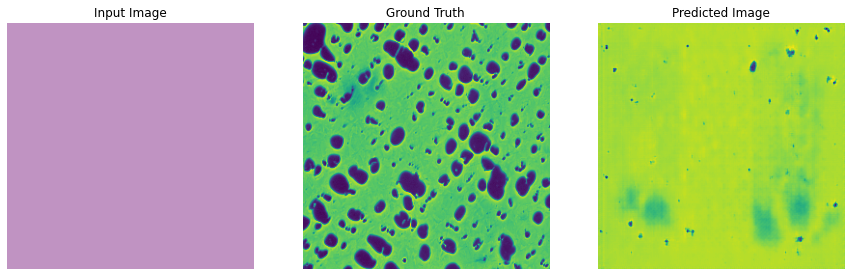

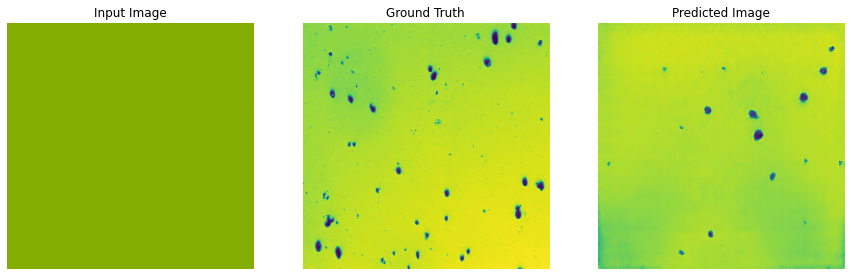

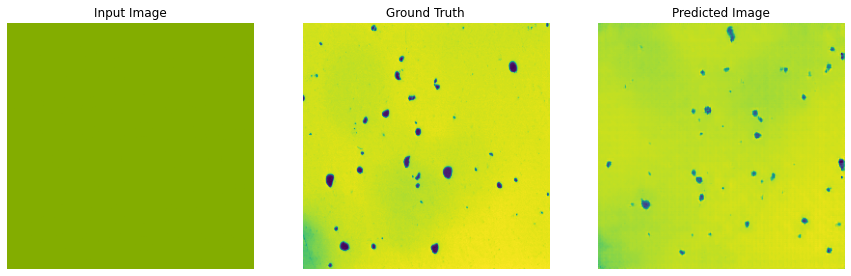

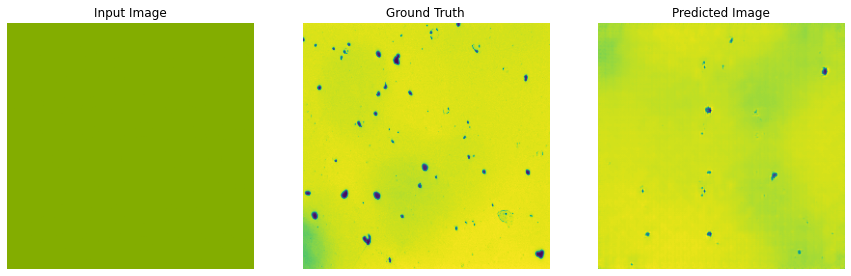

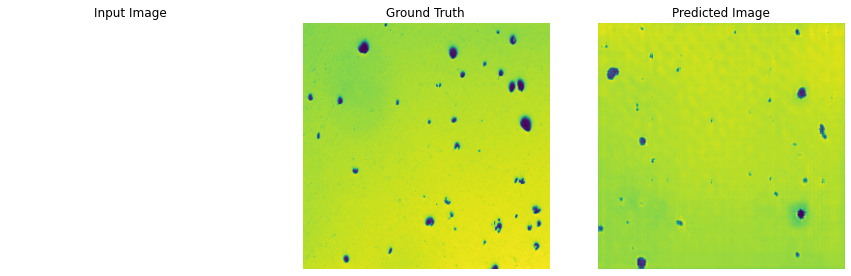

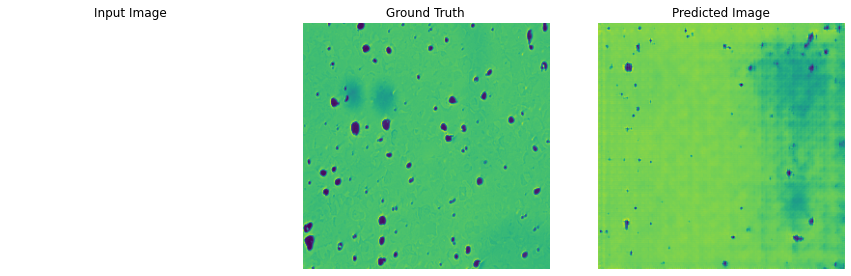

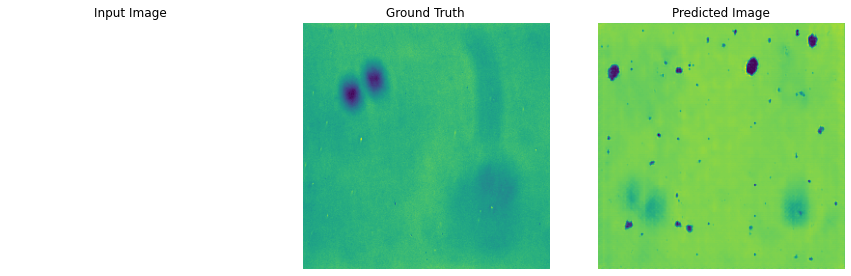

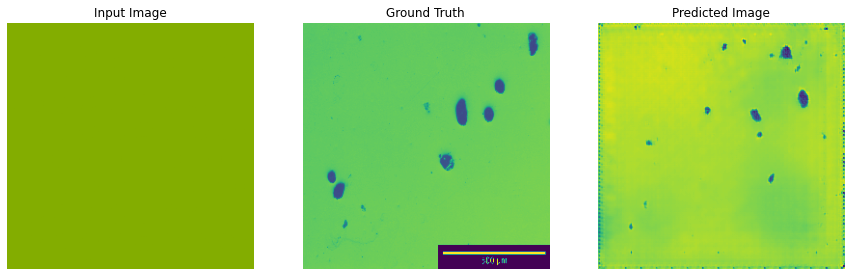

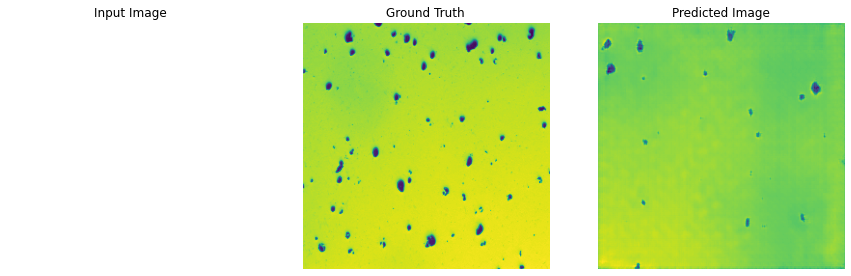

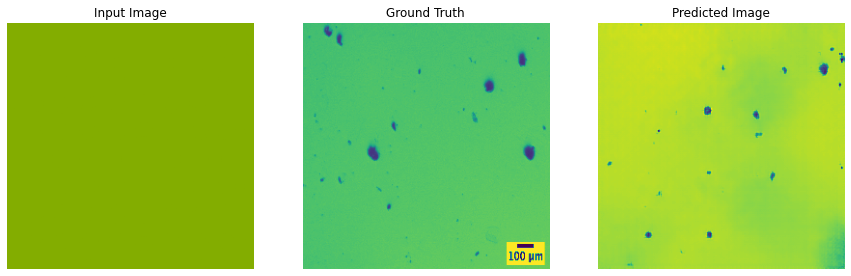

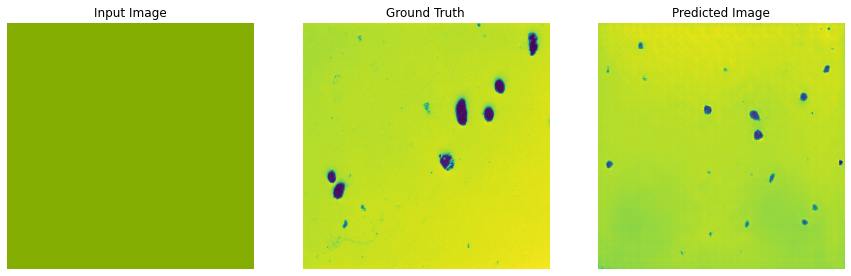

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(len(test_dataset)):
  generate_images(generator, inp, tar)

In [49]:
def save_predictions():
    files = glob(point_path + 'test\\*.png')
    for file in files:
        inp, tar = load_image_test(file)
        name = list(file.split('\\'))[-1]
        pic = save_generate_images(generator, np.reshape(inp, (1,256,256,4)), np.reshape(tar, (1,256,256,1)))
        cv2.imwrite('p2p_ori_prediction\\' + name, pic*255)

In [50]:
save_predictions()